A notebook to test the scanpro tool.

The propeller tool was developed originally for R and is integrated in the package "speckle" (Belinda Phipson, Choon Boon Sim, Enzo R Porrello, Alex W Hewitt, Joseph Powell, Alicia Oshlack).

Since propeller uses functionalities from the package "limma", these functions has been reimplemented to be used by scanpro.

The dataset used in this tutorial is the same used in the "speckle" vignette.

In [1]:
import anndata as ad
import numpy as np

from scanpro import scanpro
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props

In [2]:
# Set seed to make simulations reproducible
np.random.seed(1)

-------------

# Load anndata
* anndata.obs table has to include 3 columns:
    - condition
    - sample
    - clusters/celltypes

In [3]:
adata = ad.read_h5ad('scanpro_tutorial.h5ad')
adata

AnnData object with n_obs × n_vars = 2802 × 13575
    obs: 'sample', 'group', 'cluster'
    uns: 'color_set', 'infoprocess'

In [4]:
adata.obs

,sample,group,cluster
CELL_000001,S1,10x,HCC827
CELL_000002,S1,10x,H1975
CELL_000003,S1,10x,HCC827
CELL_000004,S1,10x,HCC827
CELL_000005,S1,10x,HCC827
...,...,...,...
CELL_000140,S6,dropseq,H2228
CELL_000233,S6,dropseq,H1975
CELL_000082,S6,dropseq,HCC827
CELL_000012,S6,dropseq,H1975


--------------

# Run scanpro
* You can use the wrapper function "scanpro". 
#### Parameters are:
    - anndata object
    - clusters: name of clusters/celltypes column in obs table
    - sample: name of sample column in obs table
    - cond: name of condition/group column in obs table
    - transform: type of transformation; logit or arcsin, default is logit

In [5]:
out = scanpro.scanpro(adata, clusters_col='cluster', samples_col='sample', conds_col='group', transform='logit')

out.results

There are more than 2 conditions. ANOVA will be performed...
Done!


,baseline_props,mean_props_10x,mean_props_celseq,mean_props_dropseq,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
H1975,0.357959,0.339246,0.394154,0.388881,3.994837,0.018410,0.050034
H2228,0.332263,0.348115,0.297449,0.311114,3.400526,0.033356,0.050034
HCC827,0.309779,0.312639,0.308397,0.300004,0.207697,0.812453,0.812453


### the `scanpro` function generates a ScanproResult object that has the following methods:
    - results: returns the results as a dataframe
    - props: returns clusters proportions as a dataframe
    - prop_trans: returns transformed proportions as a dataframe
    - counts: returns counts as a dataframe
    - design: returns the design matrix
    - plot and plot_samples: for plotting

In [6]:
out.props

cluster,H1975,H2228,HCC827
sample,,,
S1,0.347006,0.349223,0.303770
S2,0.331486,0.347006,0.321508
S3,0.416049,0.295625,0.288326
S4,0.372259,0.299274,0.328468
S5,0.408879,0.288895,0.302226
S6,0.368884,0.333333,0.297783


-----------

## Visualisation of proportions for each condition in each cluster
#### You can plot proportion per condition using `out.plot()` function. Parameters are:
    - kind: kind of plot: `stripplot`, `barplot` or `boxplot`
    - clusters: specify which clusters you want to plot, default is all
    - save: path to where you want to save the plot
#### or `out.plot_samples()` to plot a bar plot of proportions of clusters in samples. Parameters are:
    - stacked: True for stacked bar plot
    - x: Whether samples or clusters should be on the x axis
    - save: path to where you want to save the plot

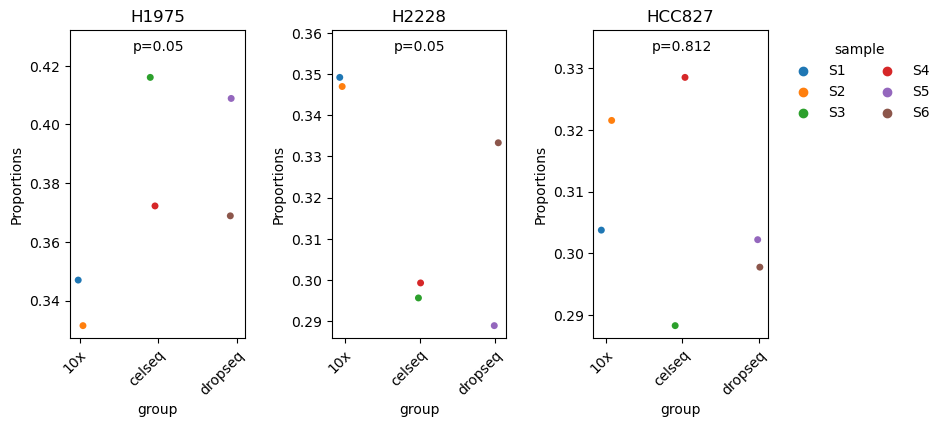

In [7]:
out.plot()

You can use `kind` to set different styles for the plot:

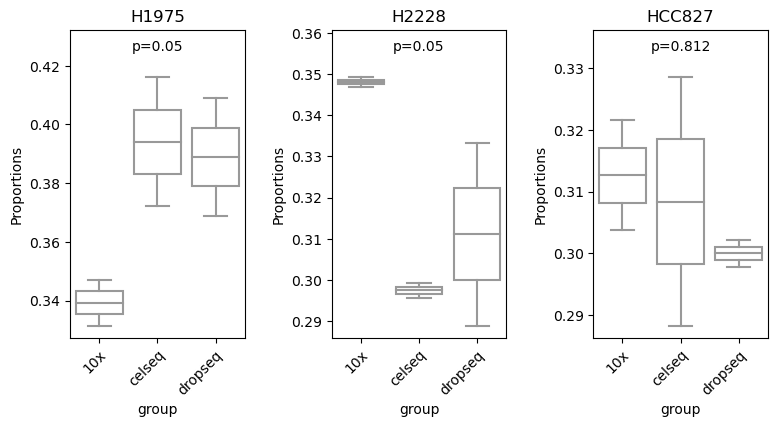

In [8]:
out.plot(kind="boxplot")

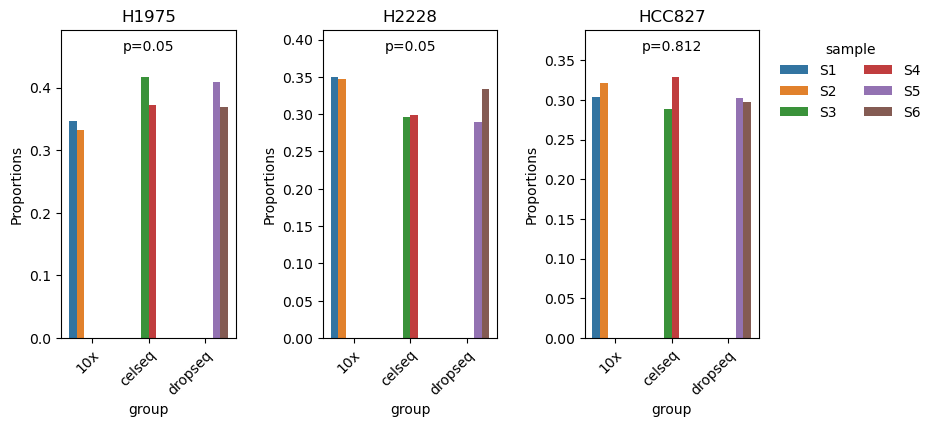

In [9]:
out.plot(kind="barplot")

You can use `clusters` to limit the clusters shown:

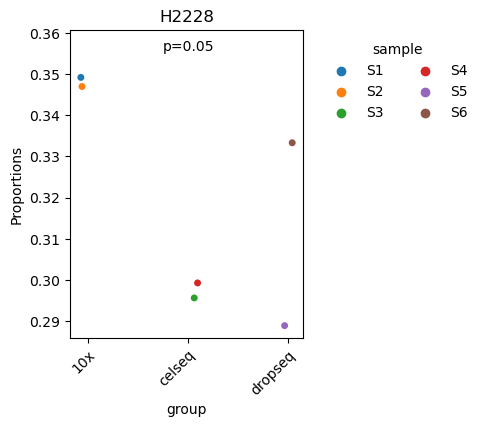

In [10]:
out.plot(clusters=["H2228"])

Proportions of cells per sample can be plotted with `plot_samples`:

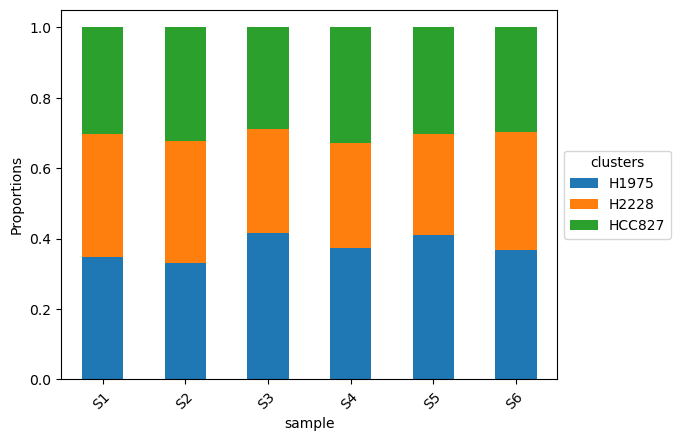

In [11]:
out.plot_samples(stacked=True)

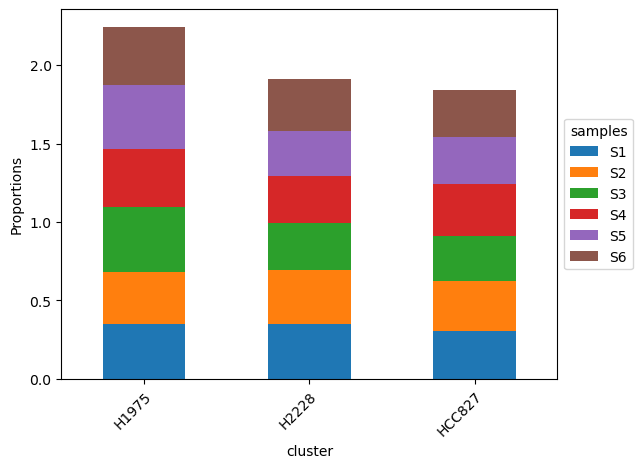

In [12]:
out.plot_samples(stacked=True, x="clusters")

------

## Test specific conditions
* by using the parameter `conditions` you can specify conditions of interests you want to compare instead of comparing all the conditions

In [13]:
out = scanpro.scanpro(adata, clusters_col='cluster', samples_col='sample', 
                              conds_col='group', transform='logit', conditions=['10x', 'celseq'])

out.results

There are 2 conditions. T-Test will be performed...
Done!


,baseline_props,mean_props_10x,mean_props_celseq,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
H1975,0.357959,0.339246,0.394154,0.860694,-2.559883,0.030693,0.049133
H2228,0.332263,0.348115,0.297449,1.170334,2.520252,0.032755,0.049133
HCC827,0.309779,0.312639,0.308397,1.013756,0.225837,0.826373,0.826373


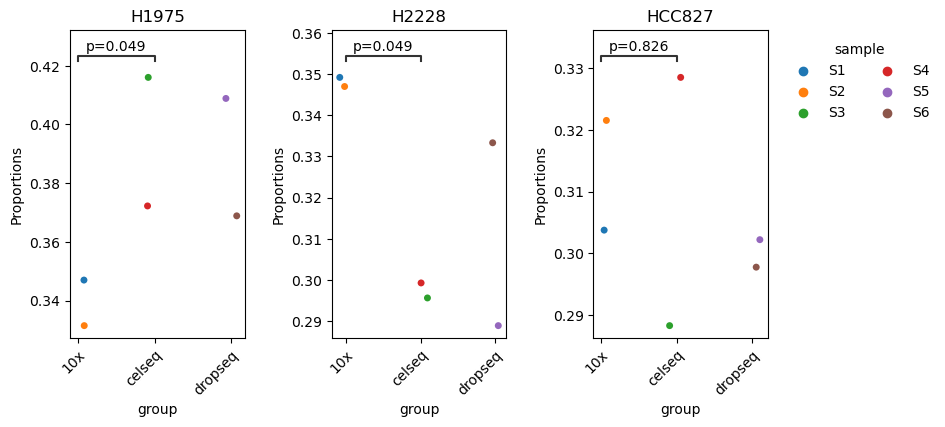

In [14]:
out.plot()

---------------

## Bootstrapping method
#### The bootstrapping method will run for non-replicated datasets in the following scenarios:
    - If the number of samples in samples_col is equal to the number of conditions in conds_col
    - If samples_col is not given or set to None, the dataset is assumed to be not replicated 
    and scanpro will run the bootstrapping method by setting conds_col temporarily as samples_col

In [15]:
out_boot = scanpro.scanpro(adata, clusters_col='cluster', 
                           conds_col='group', 
                           transform='arcsin',
                           n_reps=4, 
                           conditions=['10x', 'celseq']
                          )

out_boot.results

Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
Simulation may take some minutes...
samples_col was not provided! conds_col will be set as samples_col
Generating 4 replicates and running 100 simulations...
Finished 100 simulations in 5.01 seconds


,baseline_props,mean_props_10x,mean_props_celseq,p_values
clusters,,,,
H1975,0.357959,0.337449,0.399201,0.546697
H2228,0.332263,0.347023,0.299389,0.590815
HCC827,0.309779,0.315528,0.301410,0.624603


#### To plot the bootstrapping results, use the `plot` function

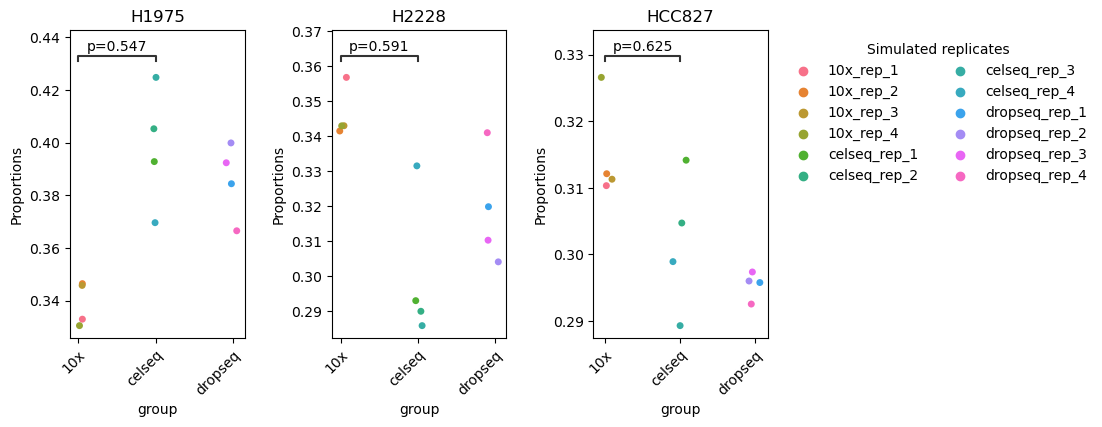

In [16]:
out_boot.plot()

-----------

## Scanpro workflow

* The scanpro function is a wrapper function, to have more controls you can perform the steps below and see how the scanpro
function works

#### Get proportions and transformed proportions using `get_transformed_props` function

In [17]:
counts, props, prop_trans = get_transformed_props(adata, sample_col='sample', cluster_col='cluster', transform='logit')

In [18]:
counts

cluster,H1975,H2228,HCC827
sample,,,
S1,313,315,274
S2,299,313,290
S3,114,81,79
S4,102,82,90
S5,92,65,68
S6,83,75,67


In [19]:
props

cluster,H1975,H2228,HCC827
sample,,,
S1,0.347006,0.349223,0.303770
S2,0.331486,0.347006,0.321508
S3,0.416049,0.295625,0.288326
S4,0.372259,0.299274,0.328468
S5,0.408879,0.288895,0.302226
S6,0.368884,0.333333,0.297783


In [20]:
prop_trans

cluster,H1975,H2228,HCC827
sample,,,
S1,-0.632323,-0.622568,-0.829180
S2,-0.701460,-0.632323,-0.746761
S3,-0.340830,-0.867255,-0.902358
S4,-0.523429,-0.849892,-0.715006
S5,-0.370631,-0.899354,-0.835761
S6,-0.537998,-0.693147,-0.856777


In [21]:
# proportions of each cluster in all samples
baseline_props = adata.obs['cluster'].value_counts()/adata.obs.shape[0]
baseline_props

cluster
H1975     0.357959
H2228     0.332263
HCC827    0.309779
Name: count, dtype: float64

#### Create design matrix using `create_design` function. The matrix has samples as rows and conditions and columns, whith 1s and 0s to specify which condition belongs to which sample (independent variables). The design matrix will be used as the X matrix in the linear model fit.
##### Parameters:
    - data: anndata object, or a pandas dataframe
    - samples: name of samples column
    - conds: name of conditions/groups column

In [22]:
design = create_design(data=adata, samples='sample', conds='group')
design

group,10x,celseq,dropseq
sample,,,
S1,1,0,0
S2,1,0,0
S3,0,1,0
S4,0,1,0
S5,0,0,1
S6,0,0,1


In [23]:
# for anova -> more than 2 conditions/groups
# The coef parameter specify the columns in the design matrix containing conditions of interest
# that you want to compare
coef = np.arange(len(design.columns))
coef

array([0, 1, 2])

#### Since we have more than 2 conditions, use the function `anova` to compare. If you have two conditions or want to only compare two, then specify a contras variable `cont = [1, -1]` with 1 and -1 match the columns of the design matrix with two conditions you want to compare. if the design matrix has more than two conditions but you only want to compare two, put 1 and -1 where they match the columns of interest and fill the rest with 0s, in this case, to compare 10x and celseq: `cont = [1, -1, 0]`

In [24]:
scanpro.anova(props, prop_trans, design, coef, robust=True)

,mean_props_10x,mean_props_celseq,mean_props_dropseq,f_statistics,p_values,adjusted_p_values
clusters,,,,,,
H1975,0.339246,0.394154,0.388881,3.994837,0.018410,0.050034
H2228,0.348115,0.297449,0.311114,3.400526,0.033356,0.050034
HCC827,0.312639,0.308397,0.300004,0.207697,0.812453,0.812453


#### Additionally, you can specify cofactors of interest and add them to the design matrix, either specify cofactor columns in the adata.obs as parameter `cofactor` to the `create_design` function, or add it manually to the design matrix. In our case, we will add pair information that specifies which sample is a replicate

In [25]:
X = design.iloc[:,coef]
N = len(X)  # number of samples
p = len(X.columns)  # number of conditions

In [26]:
# add pair information to the design matrix as cofactor
cont = np.tile([1, 2], N//2)
new_design = design.copy()
new_design['pair'] = cont
new_design

group,10x,celseq,dropseq,pair
sample,,,,
S1,1,0,0,1
S2,1,0,0,2
S3,0,1,0,1
S4,0,1,0,2
S5,0,0,1,1
S6,0,0,1,2


In [27]:
# run anova, taking into account pair information
scanpro.anova(props, prop_trans, new_design, coef, robust=True)

,mean_props_10x,mean_props_celseq,mean_props_dropseq,f_statistics,p_values,adjusted_p_values
clusters,,,,,,
H1975,0.339246,0.394154,0.388881,7.076680,0.000845,0.002534
H2228,0.348115,0.297449,0.311114,6.023885,0.002420,0.003630
HCC827,0.312639,0.308397,0.300004,0.367926,0.692169,0.692169


In [28]:
# to compare only 10x and celseq, specify a contrast and run t_test
contr = [1,-1,0]
scanpro.t_test(props, prop_trans, design, contr, robust=True)

,mean_props_10x,mean_props_celseq,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,
H1975,0.339246,0.394154,0.860694,-2.559883,0.030693,0.049133
H2228,0.348115,0.297449,1.170334,2.520252,0.032755,0.049133
HCC827,0.312639,0.308397,1.013756,0.225837,0.826373,0.826373
